## LIMPEZA DOS DADOS

In [315]:
import pandas as pd
import tensorflow as tf
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt

# Carregando e fazendo visualizações iniciais
df = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
test_y = pd.read_csv("gender_submission.csv")
df.set_index('PassengerId')
test_y.set_index('PassengerId')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [316]:
print(df.nunique()) # Verificando a quantidade de valores nulos


PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64


Aqui se pode verificar que não há discrepâncias claras de quantidade de valores categoricos parar as colunas categóricas

- Verificação dos valores nulos:

In [317]:
print("TRAIN:")
print(df.isna().sum()) # Verificando se há valores nulos
print("TEST:")
print(test.isna().sum())


TRAIN:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
TEST:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


Aqui vemos uma grande quantidade de valores nulos em Cabin, o que indica que remover a coluna seria uma boa escolha. Além disso, precisamos encontrar uma maneira de tratar as idades que estão faltando.

- Verificação das correlações:

C:\Users\renae\AppData\Local\Temp\ipykernel_30508\4139570970.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(correl.corr())


<Axes: >

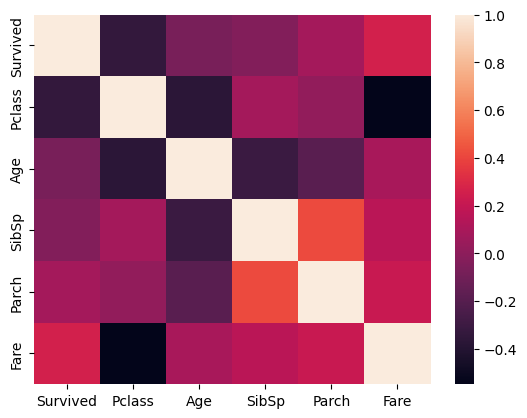

In [318]:
correl = df.drop('PassengerId', axis=1)
sb.heatmap(correl.corr())

A partir do heatmap não foi possível encontrar boas correlações e nem mesmo uma boa coluna a partir da qual inferir os valores de idade que estão faltando no dataset original

- Verificação dos valores categóricos:

In [319]:
print(df.dtypes)

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


As colunas Ticket, Name e Cabin podem ser removidas por serem inerentemente irrelevantes. A coluna Embarked também não parece ser relevante para a análise final.

In [320]:
cols = ['Name', 'Cabin', 'Ticket', 'Embarked']
df.drop(cols, axis=1, inplace=True)
test.drop(cols, axis=1, inplace=True)
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,1,0,3,male,22.0,1,0,7.2500
1,2,1,1,female,38.0,1,0,71.2833
2,3,1,3,female,26.0,0,0,7.9250
3,4,1,1,female,35.0,1,0,53.1000
4,5,0,3,male,35.0,0,0,8.0500


Agora, basta substituir os valores dos sexos para 0: male e 1: female. Por termos baixa cardinalidade, é possível usar um One-Hot Encoder

In [321]:
from sklearn.preprocessing import OneHotEncoder

In [322]:
hot_enc = OneHotEncoder()
df_hot = pd.get_dummies(df['Sex'])
test_hot = pd.get_dummies(test['Sex'])

df = df.drop(['Sex'], axis='columns')
test = test.drop(['Sex'], axis='columns')

df = pd.concat([df, df_hot], axis='columns')
test = pd.concat([test, test_hot], axis='columns')
df.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,female,male
0,1,0,3,22.0,1,0,7.2500,0,1
1,2,1,1,38.0,1,0,71.2833,1,0
2,3,1,3,26.0,0,0,7.9250,1,0
3,4,1,1,35.0,1,0,53.1000,1,0
4,5,0,3,35.0,0,0,8.0500,0,1


- Análise de Outliers para o treino

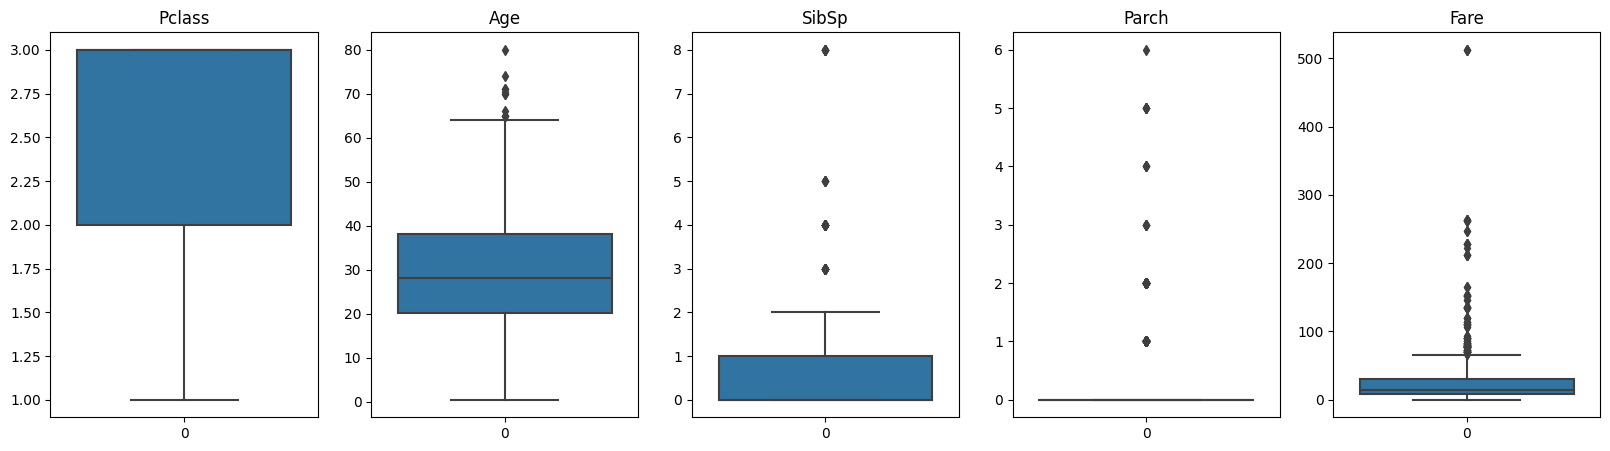

In [323]:
# Criando dataframe para verificar outliers
out = df.drop(['female', 'male', 'PassengerId', 'Survived'], axis=1)

fig, axs = plt.subplots(ncols=out.columns.size, figsize=(20,5))
for i in range(out.columns.size):
    sb.boxplot(data=out.iloc[:, i], ax=axs[i])
    axs[i].set_title(out.columns[i])
plt.show()

Aqui podemos ver que existem dois valores de outliers para a idade, alguns para SibSp e Parch e muitos para Fare. Nesse caso, não tendo descartado passenger anteriormente, talvez esse seja um bom motivo. Embora passageiros que tenham pago mais possam estar acomodadas em locais específicos que podem ter sido mais ou menos afetados, essa informação também deve estar representada em Pclass, no entanto, o mapa de correlação visto anteriormente nos diz que Fare tem uma das melhores relações com Survived, portanto talvez não seja razoável removê-la. À princípio, irei removê-la, mas também é possível realizar teste com a coluna.

In [324]:
df.drop('Fare', axis=1, inplace=True)
test.drop('Fare', axis=1, inplace=True)

Por cautela, podemos verificar a contagem de passageiros para cada valor de SibSp e Parch a partir dos valores que estão fora dos desvios padrão:

In [325]:
print("Parch")
for i in range(1, df['Parch'].max()):
    print(f'{i}:', len(df[df['Parch'] == i]))

print("SibSp")
for i in range(2, df['SibSp'].max()):
    print(f'{i}:', len(df[df['SibSp'] == i]))
df.shape


Parch
1: 118
2: 80
3: 5
4: 4
5: 5
SibSp
2: 28
3: 16
4: 18
5: 5
6: 0
7: 0


(891, 8)

 Aqui podemos ver que é razoável remover os outliers a partir de 3 em Parch e a partir de 3 em SibSp

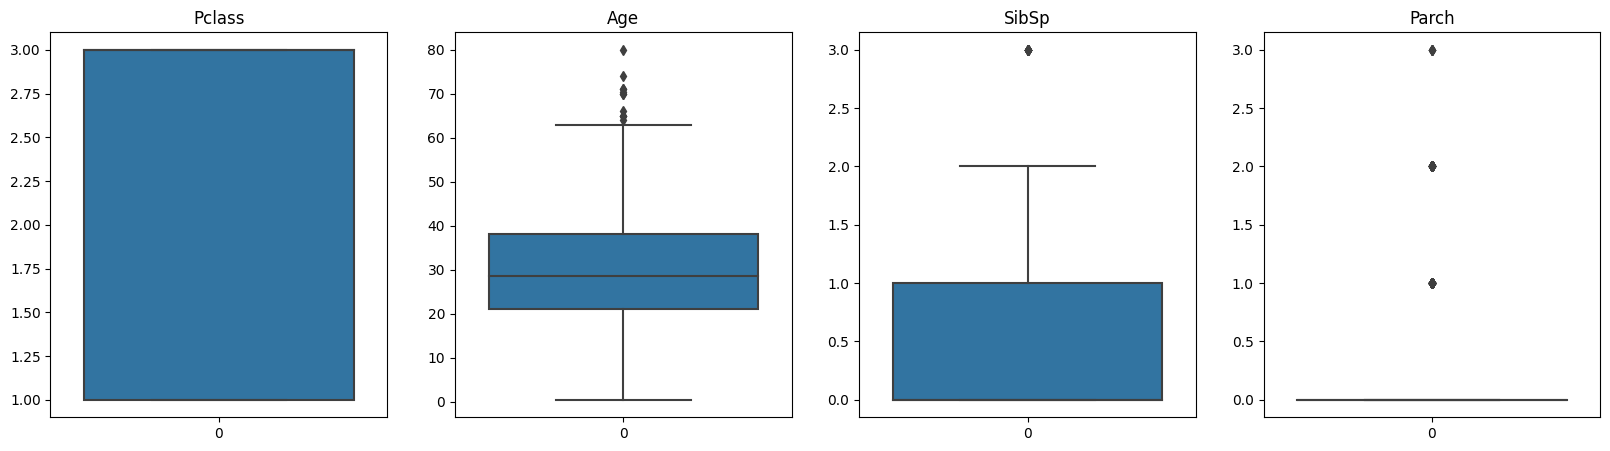

In [326]:
df = df[(df['Parch'] <= 3) & (df['SibSp'] <= 3)]
out = df.drop(['female', 'male', 'PassengerId', 'Survived'], axis=1)

fig, axs = plt.subplots(ncols=out.columns.size, figsize=(20,5))
for i in range(out.columns.size):
    sb.boxplot(data=out.iloc[:, i], ax=axs[i])
    axs[i].set_title(out.columns[i])
plt.show()

Assim removemos a maior parte dos outliers sem remover uma quantidade extremamente grande de linhas da tabela.

- Imputation

Por fim, precisamos encontrar uma forma de ajustar os valores perdidos de idade. À princípio, podemos imputar os valores com base na média. É interessante notar que o dataset de teste também possui idades não preenchidas. Nesse caso, no entanto, é melhor remover as linhas, haja visto que precisamos testar com dados completos.

In [327]:
from sklearn.impute import SimpleImputer

In [328]:
imputer = SimpleImputer()
df_imputed = pd.DataFrame(imputer.fit_transform(df))

# Devolvendo os nomes das colunas:
df_imputed.columns = df.columns
df_imputed.set_index('PassengerId')
print(df_imputed.head())
print(df_imputed.isna().sum())
print("Média idade: ", df['Age'].mean())
df = df_imputed

   PassengerId  Survived  Pclass   Age  SibSp  Parch  female  male
0          1.0       0.0     3.0  22.0    1.0    0.0     0.0   1.0
1          2.0       1.0     1.0  38.0    1.0    0.0     1.0   0.0
2          3.0       1.0     3.0  26.0    0.0    0.0     1.0   0.0
3          4.0       1.0     1.0  35.0    1.0    0.0     1.0   0.0
4          5.0       0.0     3.0  35.0    0.0    0.0     0.0   1.0
PassengerId    0
Survived       0
Pclass         0
Age            0
SibSp          0
Parch          0
female         0
male           0
dtype: int64
Média idade:  30.264566813509543


In [329]:
test = test[~test['Age'].isna()]
test_y = test_y[test_y.PassengerId.isin(test.PassengerId)] # Removendo os valores da resposta
print(test_y.shape)
print(test.shape)

(332, 2)
(332, 7)


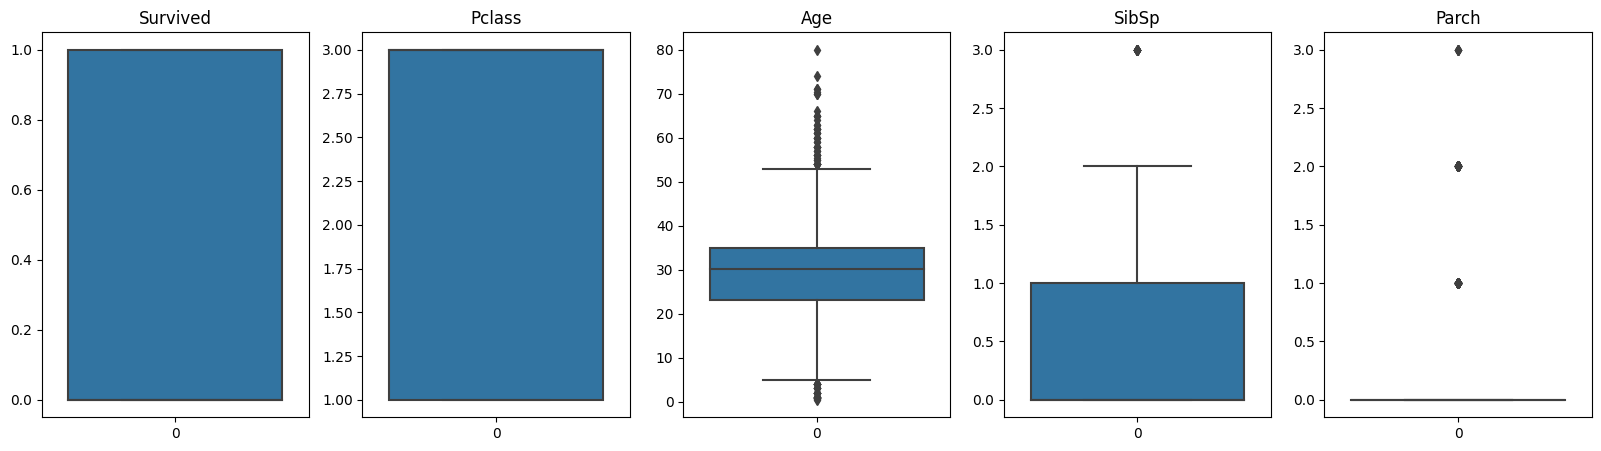

In [330]:
# Criando dataframe para verificar outliers
out = df.drop(['female', 'male', 'PassengerId'], axis=1)

fig, axs = plt.subplots(ncols=out.columns.size, figsize=(20,5))
for i in range(out.columns.size):
    sb.boxplot(data=out.iloc[:, i], ax=axs[i])
    axs[i].set_title(out.columns[i])
plt.show()

In [331]:
df['PassengerId'] = df['PassengerId'].astype(int) # Corrigindo o tipo do Id
df = df.set_index('PassengerId')
df

,Survived,Pclass,Age,SibSp,Parch,female,male
PassengerId,,,,,,,
1,0.0,3.0,22.000000,1.0,0.0,0.0,1.0
2,1.0,1.0,38.000000,1.0,0.0,1.0,0.0
3,1.0,3.0,26.000000,0.0,0.0,1.0,0.0
4,1.0,1.0,35.000000,1.0,0.0,1.0,0.0
5,0.0,3.0,35.000000,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...
887,0.0,2.0,27.000000,0.0,0.0,0.0,1.0
888,1.0,1.0,19.000000,0.0,0.0,1.0,0.0
889,0.0,3.0,30.264567,1.0,2.0,1.0,0.0


Aqui temos a nova tabela pronta para ser treinada pelos modelos de Machine Learning.

In [332]:
test = test.set_index('PassengerId')
test_y = test_y.set_index('PassengerId')
print(test)

             Pclass   Age  SibSp  Parch  female  male
PassengerId                                          
892               3  34.5      0      0       0     1
893               3  47.0      1      0       1     0
894               2  62.0      0      0       0     1
895               3  27.0      0      0       0     1
896               3  22.0      1      1       1     0
...             ...   ...    ...    ...     ...   ...
1301              3   3.0      1      1       1     0
1303              1  37.0      1      0       1     0
1304              3  28.0      0      0       1     0
1306              1  39.0      0      0       1     0
1307              3  38.5      0      0       0     1

[332 rows x 6 columns]


# TREINANDO MODELOS

Agora já temos datasets de treino e de teste e podemos começar a comparar modelos.

- #### RANDOM FOREST

In [333]:
from sklearn.metrics import f1_score, accuracy_score, mean_absolute_error, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

Primeiramente, precisamos separar os datasets em treino e validação

In [334]:
X = df.drop('Survived', axis=1)
y = df.Survived

train_x, val_x, train_y, val_y = train_test_split(X, y, random_state=1)

E também façamos o Min-Max Scaling da variável Age

In [335]:
max = train_x['Age'].max()
min = train_x['Age'].min()

for i in range(train_x['Age'].size):
    train_x['Age'].iloc[[i]] = (train_x['Age'].iloc[[i]] - min) / (max - min)

print(train_x['Age'].max())
print(train_x['Age'].min())

1.0
0.0


Vamos verificar o balanceamento do dataset

In [336]:
print(f'Porcentagem de 0s: {round((train_y[train_y == 0].count() / train_y.shape[0]) * 100)}%')
print(f'Porcentagem de 1s: {round((train_y[train_y == 1].count() / train_y.shape[0]) * 100)}%')

Porcentagem de 0s: 61%
Porcentagem de 1s: 39%


Embora o balanceamento não esteja perfeito, deve ser suficiente para uma boa predição dos modelos

Agora implementando o modelo de Random Forest

In [337]:
rf = RandomForestClassifier(random_state=1, n_estimators=1000, criterion='log_loss')
rf.fit(train_x, train_y)

# Observando o erro no treinamento
predict = rf.predict(val_x)
rf_f1 = f1_score(predict, val_y)
print("Validation f1-score for Random Forest: {}".format(rf_f1))

Validation f1-score for Random Forest: 0.456140350877193


Aqui temos um erro aproximadamente razoável, para o modelo treinado com o subset de treino e validação, vamos ver como ele lida com as previsões.

No entanto, como estamos lidando com uma saída booleana, podemos verificar outras métricas de assertividade do modelo.

Nesse caso, Accuracy, Precision e Recall:

In [338]:
# Verificação de métricas
def metricas(modelo):
    valores_corretos = np.array(test_y.squeeze())
    predict_final = modelo.predict(test)

    acc = accuracy_score(predict_final, valores_corretos)
    recall = recall_score(predict_final, valores_corretos)
    precision = precision_score(predict_final, valores_corretos)
    f1score = f1_score(predict_final, valores_corretos)

    print(f'Accuracy: {round(acc * 100)}%')
    print(f'Precision: {round(precision * 100)}%')
    print(f'Recall: {round(recall * 100)}%')
    print(f'f1-score: {round(f1score * 100)}%')

In [339]:
metricas(rf)

Accuracy: 80%
Precision: 49%
Recall: 100%
f1-score: 66%


Aqui verificamos boa acurácia, mediano f1-score e ótimo recall, embora tenhamos precisão razoável. Isso significa que o modelo não tem muitos false negatives, ou seja, é um modelo conservador.

- Teste de hiperparâmetros

Agora vamos fazer testes com diferentes parâmetros para as árvores para verificar se podemos encontrar algum modelo mais adequado.

Primeiramento, uma floresta com 200 árvores e critério de erro "gini"

In [340]:
rf_2 = RandomForestClassifier(n_estimators=200, criterion="gini", verbose=0, random_state=1)

In [341]:
rf_2.fit(train_x, train_y)

predict = rf_2.predict(val_x)
rf_f1 = f1_score(predict, val_y)
print("f1-score para o conjunto de validação:", rf_f1)

f1-score para o conjunto de validação: 0.456140350877193


In [342]:
metricas(rf_2)

Accuracy: 80%
Precision: 49%
Recall: 100%
f1-score: 66%


Aqui não vemos muitas mudanças na capacidade de predição do modelo

Agora, uma floresta com 300 árvores usando entropy.

In [343]:
rf_3 = RandomForestClassifier(n_estimators=300, criterion="entropy", verbose=0, random_state=1)

In [344]:
rf_3.fit(train_x, train_y)

predict = rf_3.predict(val_x)
rf_f1 = f1_score(predict, val_y)
print("f-1 score para o conjunto de validação:", rf_f1)

f-1 score para o conjunto de validação: 0.456140350877193


In [345]:
metricas(rf_3)

Accuracy: 80%
Precision: 49%
Recall: 100%
f1-score: 66%


Novamente, não se observa grandes mudanças no modelo

- ### LOGISTIC REGRESSOR

In [346]:
from sklearn.linear_model import LogisticRegression

In [347]:
lr = LogisticRegression(penalty='l2', class_weight=None)

lr.fit(train_x, train_y)
predict = lr.predict(val_x)
print(f'f1-score for Logistic Regression training: {f1_score(predict, val_y)}')
print(f'Accuracy for Logistic Regression training: {accuracy_score(predict, val_y)}')

predict[:30]

f1-score for Logistic Regression training: 0.0
Accuracy for Logistic Regression training: 0.5915492957746479


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Note que o modelo está prevendo sempre o valor 0, o que mantém o f1 score em 0, por não ter recall, mas garante uma acurácia razoável. Isso pode ser um indicativo de que os datasets de treino estão mal balanceados.

Vamos fazer um undersampling para tentar melhorar os resultados de previsão do modelo:

In [348]:
def balance_count (series):
    print(f'Number of 1s: {series[series == 1].count()}')
    print(f'Number of 0s: {series[series == 0].count()}')

balance_count(train_y)

Number of 1s: 251
Number of 0s: 387


In [349]:
dropped = []
count = 0
i = 0
while(count < 100):
    if train_y.iloc[i] == 0:
        dropped.append(train_y.index[i])
        count += 1
    i += 1

mask = ~train_y.index.isin(dropped)
new_train_y = train_y[mask]
new_train_x = train_x[mask]
balance_count(new_train_y)

Number of 1s: 251
Number of 0s: 287


Agora podemos verificar novamente a qualidade do logistic regressor

In [351]:
lr.fit(new_train_x, new_train_y)

predict = lr.predict(val_x)
predict.sum()

print(f'Acc {accuracy_score(predict, val_y)}')

Acc 0.5915492957746479
